<a href="https://colab.research.google.com/github/mljarman/DS-Unit-2-Kaggle-Challenge/blob/master/module1/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [270]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
# If you're working locally:
else:
    DATA_PATH = '../data/'

In [271]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [272]:
# split train into train and val data:
train, val = train_test_split(train, train_size=.8, test_size=.2, 
                              stratify=train['status_group'], random_state=42)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [273]:
train['status_group'].value_counts(normalize=True)
# majority class baseline is functional waterpumps 54% of the time.

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [7]:
import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

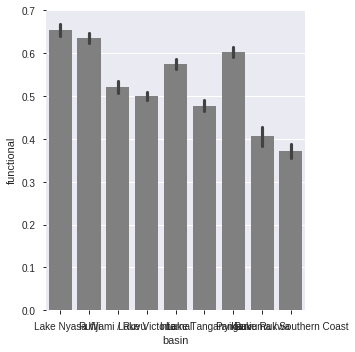

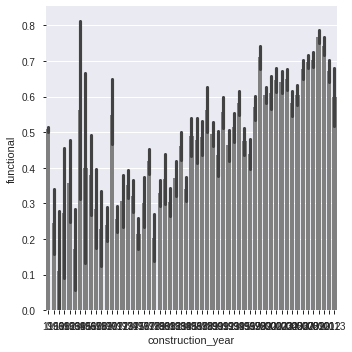

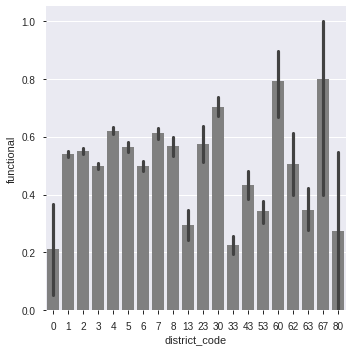

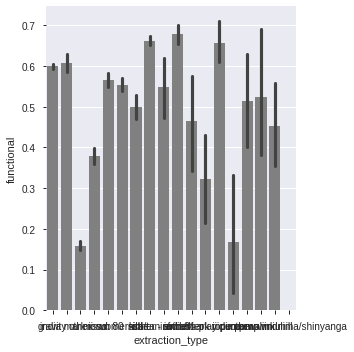

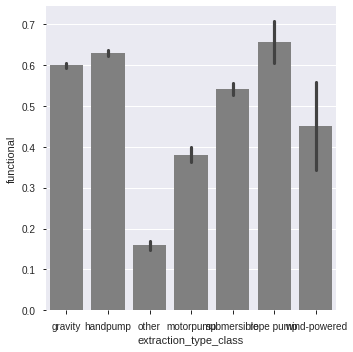

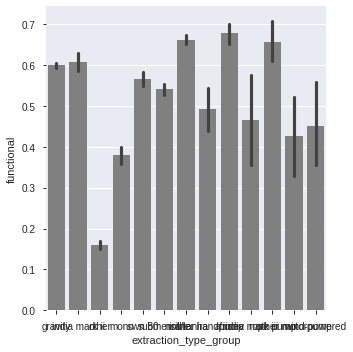

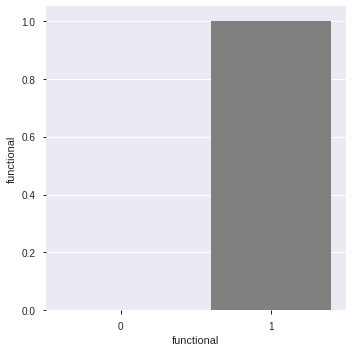

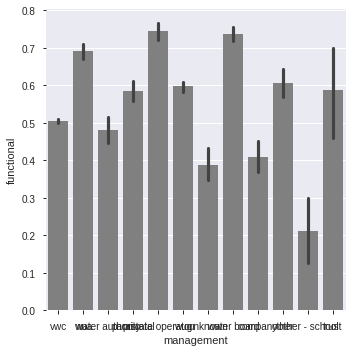

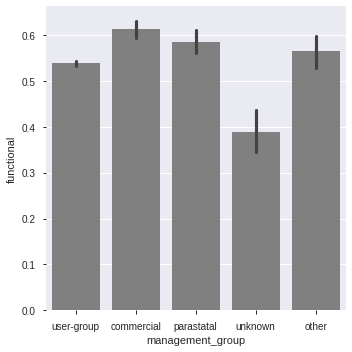

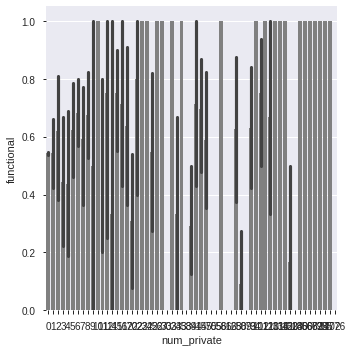

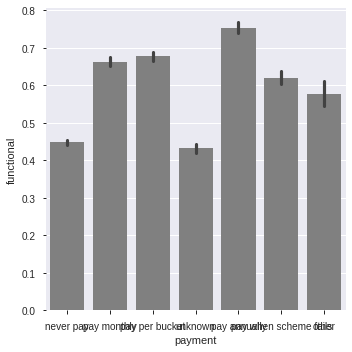

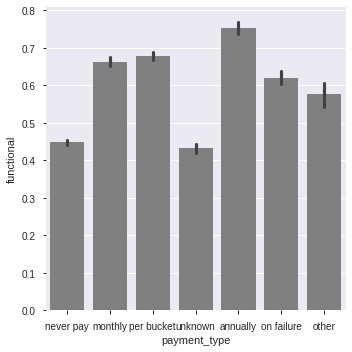

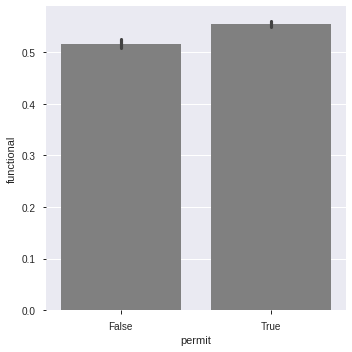

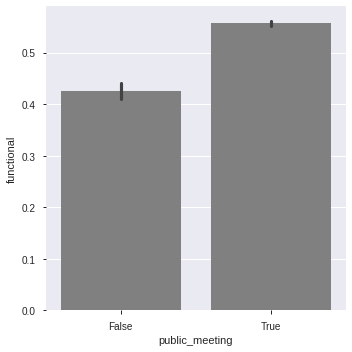

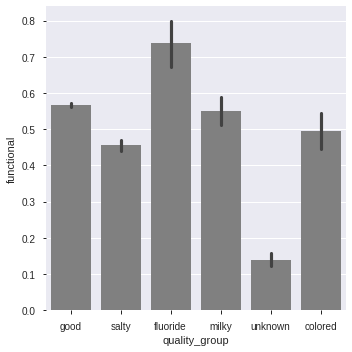

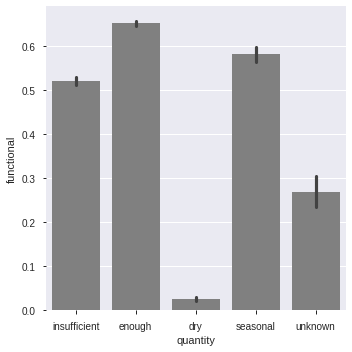

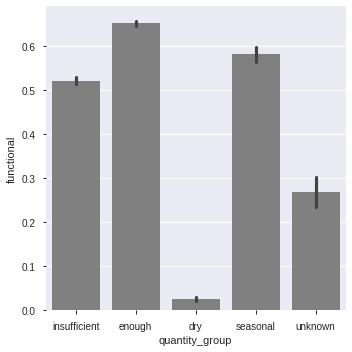

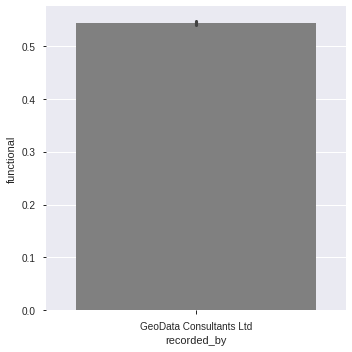

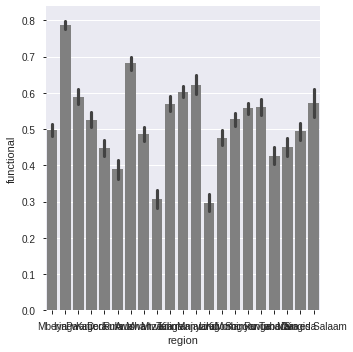

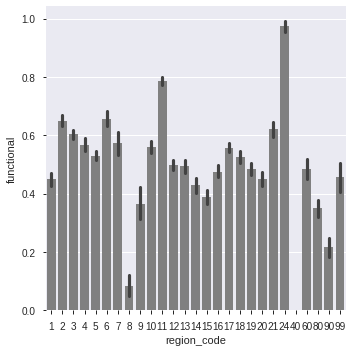

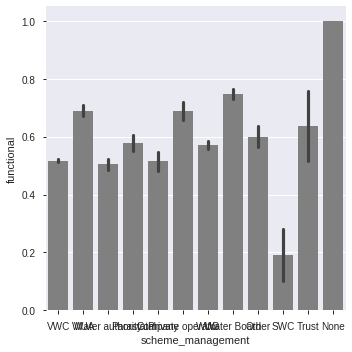

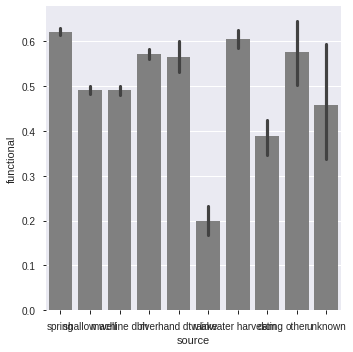

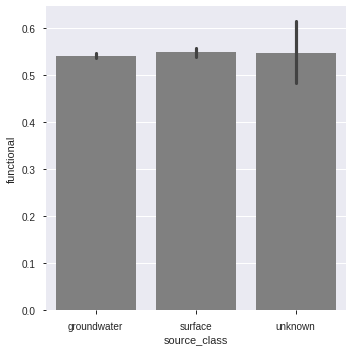

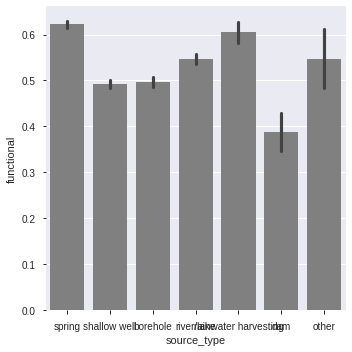

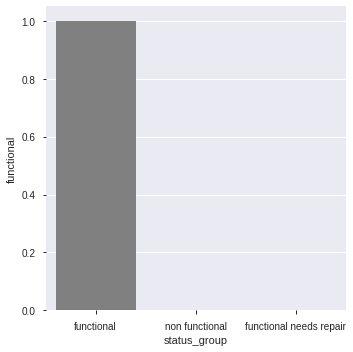

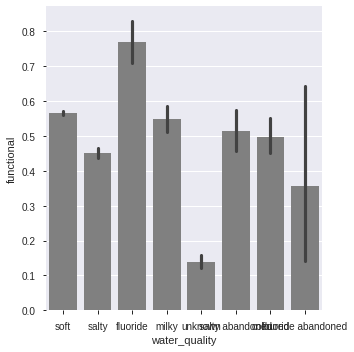

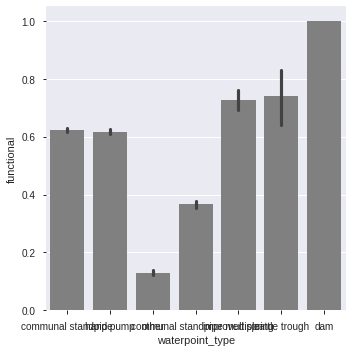

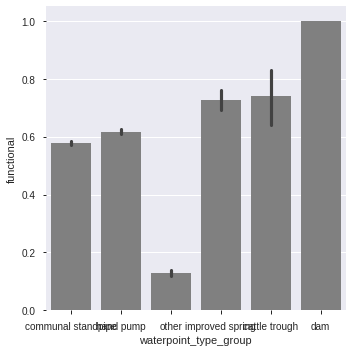

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in sorted(train.columns):
    if train[col].nunique() < 65:
        try:
            sns.catplot(x=col, y='functional', data=train, kind='bar', color='grey')
            plt.show()
        except:
            pass

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    # # don't want to impute the 0's for construction year with mean
    # # because that's 1300-ish so want to fill with median values:
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also drop target column- status group
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # drop duplicates:
    X = X.drop(columns=['quantity_group', 'payment_type'])
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
train['construction_year'].fillna(train['construction_year'].median(), inplace=True)
val['construction_year'].fillna(train['construction_year'].median(), inplace=True)
test['construction_year'].fillna(train['construction_year'].median(), inplace=True)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature ...
 
# Get a list of the top 10 neighborhoods
top5 = train['extraction_type_group'].value_counts()[:5].index
 
# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['extraction_type_group'].isin(top5), 'extraction_type_group'] = 'OTHER'
val.loc[~val['extraction_type_group'].isin(top5), 'extraction_type_group'] = 'OTHER'
test.loc[~test['extraction_type_group'].isin(top5), 'extraction_type_group'] = 'OTHER'

In [0]:
# Reduce cardinality for funder feature ...
 
# Get a list of the top 10 funders
top10 = train['funder'].value_counts()[:10].index
 
# At locations where the funder is NOT in the top 10,
# replace the funder with 'OTHER'
train.loc[~train['funder'].isin(top10), 'funder'] = 'OTHER'
val.loc[~val['funder'].isin(top10), 'funder'] = 'OTHER'
test.loc[~test['funder'].isin(top10), 'funder'] = 'OTHER'

In [0]:
top3 = train['waterpoint_type_group'].value_counts()[:3].index
 
# At locations where the waterpoint type group is NOT in the top 10,
# replace the waterpoint type group with 'OTHER'
train.loc[~train['waterpoint_type_group'].isin(top3), 'waterpoint_type_group'] = 'OTHER'
val.loc[~val['waterpoint_type_group'].isin(top3), 'waterpoint_type_group'] = 'OTHER'
test.loc[~test['waterpoint_type_group'].isin(top3), 'waterpoint_type_group'] = 'OTHER'

In [0]:
# Reduce cardinality for lga feature ...
 
# Get a list of the top 10 lga
top10 = train['lga'].value_counts()[:10].index
 
# At locations where the lga is NOT in the top 10,
# replace the lga with 'OTHER'
train.loc[~train['lga'].isin(top10), 'lga'] = 'OTHER'
val.loc[~val['lga'].isin(top10), 'lga'] = 'OTHER'
test.loc[~test['lga'].isin(top10), 'lga'] = 'OTHER'

In [292]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id', 'amount_tsh', 'gps_height'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)



ValueError: ignored

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [219]:
X_train.shape

(47520, 30)

In [220]:
X_val.shape

(11880, 30)

In [0]:
# going to look at feature importances for the decision tree:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

In [283]:
int_pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
)

int_pipeline.fit(X_train, y_train)
print('Train Accuracy', int_pipeline.score(X_train, y_train))
print('Validation Accuracy', int_pipeline.score(X_val, y_val))

Train Accuracy 0.8074705387205388
Validation Accuracy 0.7713804713804714


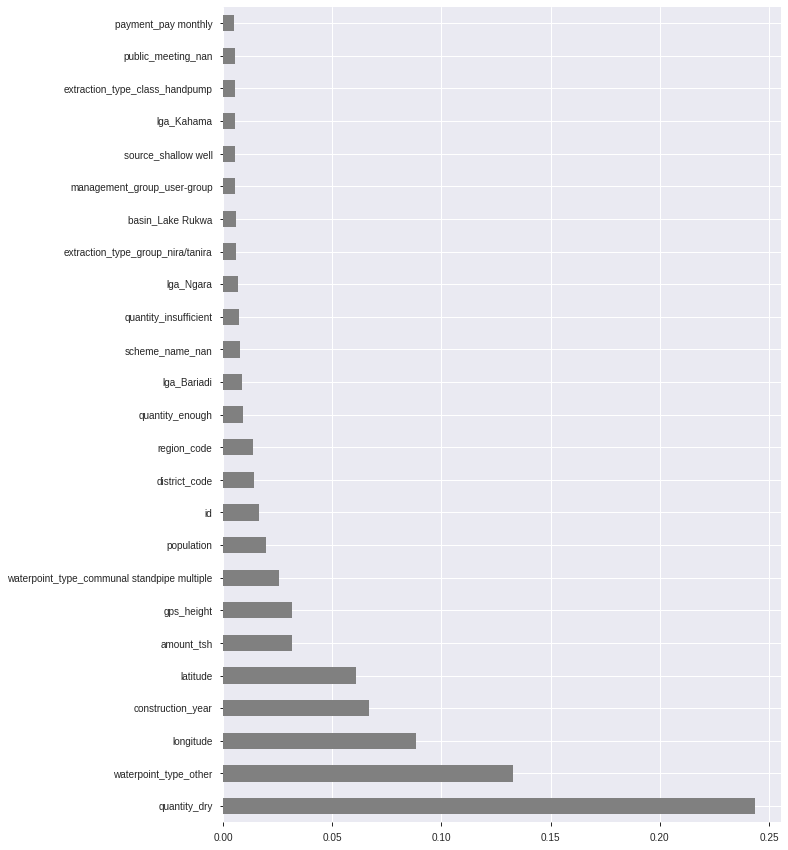

In [47]:
# feature importances:
%matplotlib inline
import matplotlib.pyplot as plt
model = int_pipeline.named_steps['decisiontreeclassifier']
encoder = int_pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10, 15))
importances.nlargest(25).plot.barh(color='grey')

In [0]:
encoded_columns

In [284]:
from sklearn.feature_selection import SelectKBest
sec_pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    SelectKBest(k=95),
    DecisionTreeClassifier(max_depth=18, random_state=42)
)


sec_pipeline.fit(X_train, y_train)
print('Train Accuracy', sec_pipeline.score(X_train, y_train))
print('Validation Accuracy', sec_pipeline.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [64] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Train Accuracy 0.8739688552188553
Validation Accuracy 0.7694444444444445


In [288]:
from sklearn.feature_selection import SelectKBest
from numpy import array
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
thi_pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    SelectKBest(k=93),
    DecisionTreeClassifier(min_samples_leaf=22, random_state=42)
)


thi_pipeline.fit(X_train, y_train)
print('Train Accuracy', thi_pipeline.score(X_train, y_train))
print('Validation Accuracy', thi_pipeline.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [64] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Train Accuracy 0.7973695286195286
Validation Accuracy 0.7632154882154882


In [286]:
from sklearn.feature_selection import SelectKBest
for_pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    

    SelectKBest(k=95),
    DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
)


for_pipeline.fit(X_train, y_train)
print('Train Accuracy', for_pipeline.score(X_train, y_train))
print('Validation Accuracy', for_pipeline.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [64] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Train Accuracy 0.8009048821548822
Validation Accuracy 0.7682659932659933


In [0]:
y_pred = thi_pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Maggie-Jarman-submission2.csv', index=False)

In [0]:
from google.colab import files
files.download('Maggie-Jarman-submission2.csv')

In [0]:
y_pred = thi_pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Maggie-Jarman-submission2.csv', index=False)